# Processing gravity data with Harmonica


In this tutorial we’ll take a tour around Harmonica, a Python library for forward modelling, inversion and processing gravity data, focusing on the processing workflow to produce a regular grid of the Bouguer gravity disturbance. 


To obtain the _Bouguer gravity disturbance_, it is necessary to calculate the _gravity disturbance_ as:
$$ \delta g(P) = g(P) - \gamma (P), $$
where $g(P)$ and $\gamma(P)$ are the observed gravity and normal gravity at point $P$ respectively.

Then, the gravitational effect produced by the known topography masses  is removed to obtain the _Bouguer gravity disturbance_ as:
$$ \delta bg(P) = \delta g(P) - g_{topo}(P), $$
where $g_{topo}(P)$ is the gravitational effect of the topography at point $P$. 

## Import libraries

In [1]:
import pyproj
import pooch
import numpy as np
import xarray as xr
import verde as vd
import boule as bl
import harmonica as hm
import matplotlib.pyplot as plt

Increase the size of the matplotlib figures (this is not necessary, it's only for the live coding presentation)

In [2]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 130

## Load South Africa gravity data

In [3]:
data = hm.datasets.fetch_south_africa_gravity()
data

,latitude,longitude,elevation,gravity
0,-34.39150,17.71900,-589.0,979724.79
1,-34.48000,17.76100,-495.0,979712.90
2,-34.35400,17.77433,-406.0,979725.89
3,-34.13900,17.78500,-267.0,979701.20
4,-34.42200,17.80500,-373.0,979719.00
...,...,...,...,...
14554,-17.95833,21.22500,1053.1,978182.09
14555,-17.98333,21.27500,1033.3,978183.09
14556,-17.99166,21.70833,1041.8,978182.69
14557,-17.95833,21.85000,1033.3,978193.18


Plot the data in longitude and latitude (geographic coordinates):

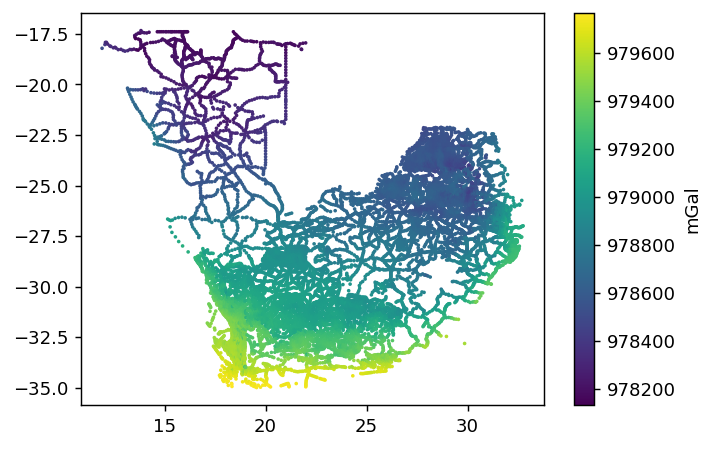

In [4]:
tmp = plt.scatter(data.longitude, data.latitude, c=data.gravity, s=1)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.show()

When we plot data in geographic coordinates, the map looks distorted, we need to project it to plain coordinates.

## Project data to plain coordinates

We will use **[pyproj](https://pypi.org/project/pyproj/)** to project as Cartesian coordinates.

In [5]:
# Set up the projection: 
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
# Project the dataset coordinates:
easting, northing = projection(data.longitude.values, data.latitude.values)

# Add these projected coordinates in the dataset as columns:
data = data.assign(easting=easting)
data = data.assign(northing=northing)
data

,latitude,longitude,elevation,gravity,easting,northing
0,-34.39150,17.71900,-589.0,979724.79,1.745161e+06,-3.589785e+06
1,-34.48000,17.76100,-495.0,979712.90,1.749298e+06,-3.600305e+06
2,-34.35400,17.77433,-406.0,979725.89,1.750610e+06,-3.585330e+06
3,-34.13900,17.78500,-267.0,979701.20,1.751661e+06,-3.559831e+06
4,-34.42200,17.80500,-373.0,979719.00,1.753631e+06,-3.593409e+06
...,...,...,...,...,...,...
14554,-17.95833,21.22500,1053.1,978182.09,2.090470e+06,-1.786775e+06
14555,-17.98333,21.27500,1033.3,978183.09,2.095395e+06,-1.789348e+06
14556,-17.99166,21.70833,1041.8,978182.69,2.138074e+06,-1.790205e+06
14557,-17.95833,21.85000,1033.3,978193.18,2.152027e+06,-1.786775e+06


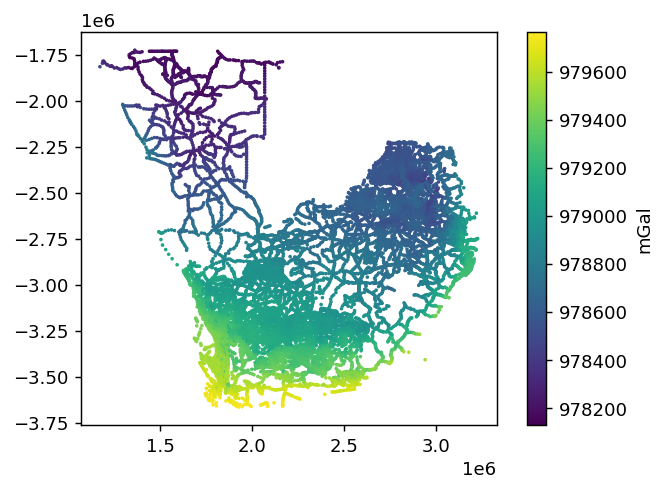

In [6]:
tmp = plt.scatter(data.easting, data.northing, c=data.gravity, s=1)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.show()

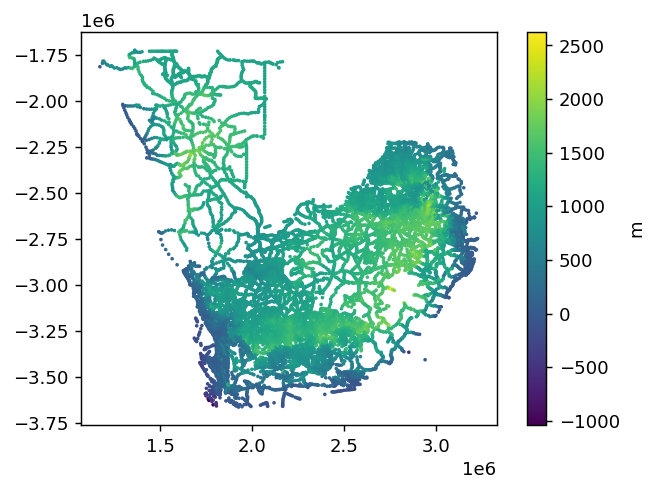

In [7]:
tmp = plt.scatter(data.easting, data.northing, c=data.elevation, s=1)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="m")
plt.show()

## Cut the dataset into a smaller region

We will cut the dataset into a smaller region using **[Verde](https://www.fatiando.org/verde)**.

In [8]:
# Set the region to cut ([W, E, S, N]):
region_deg = (25, 32, -27, -23)
 
# Get a array with dataset coordinates which are inside the region_cut: 
inside = vd.inside((data.longitude, data.latitude), region_deg)
# Get a smaller dataset and replace it in the original:
data = data[inside]
data

,latitude,longitude,elevation,gravity,easting,northing
8848,-26.26334,25.01500,1230.16,978681.38,2.463751e+06,-2.665630e+06
8849,-26.38713,25.01932,1297.00,978669.02,2.464176e+06,-2.679160e+06
8850,-26.39667,25.02499,1304.84,978669.28,2.464735e+06,-2.680203e+06
8851,-26.07668,25.04500,1165.24,978681.08,2.466705e+06,-2.645257e+06
8852,-26.35001,25.07668,1262.47,978665.19,2.469826e+06,-2.675101e+06
...,...,...,...,...,...,...
13174,-23.86333,31.51500,300.53,978776.85,3.103942e+06,-2.406088e+06
13175,-23.30000,31.52499,280.72,978798.55,3.104926e+06,-2.345890e+06
13176,-23.19333,31.54832,245.67,978803.55,3.107224e+06,-2.334520e+06
13177,-23.84833,31.57333,226.77,978808.44,3.109687e+06,-2.404481e+06


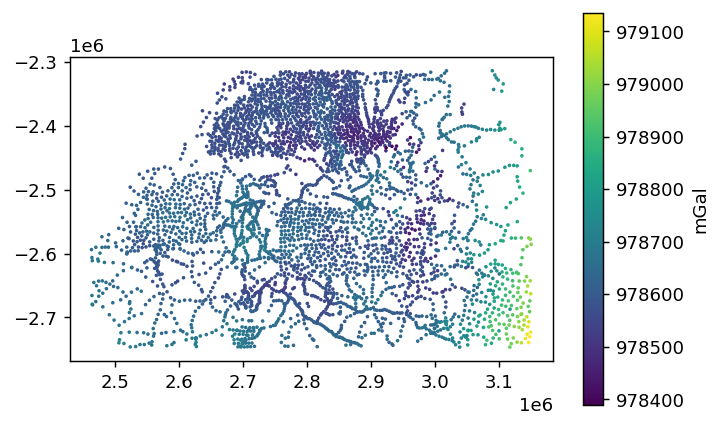

In [9]:
tmp = plt.scatter(data.easting, data.northing, c=data.gravity, s=1)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.show()

## Compute gravity disturbance

The gravity disturbance is defined as: 

$$ \delta g(P) = g(P) - \gamma(P), $$

The normal gravity $\gamma(P)$ is calculated using the reference ellipsoid _WGS84_.

We will use **[Boule](https://www.fatiando.org/boule)** to get the reference ellipsoid and calculate the normal gravity through
the `normal_gravity()` method. 
It implements the closed-form formula of [Li and Götze (2001)](http://mr.crossref.org/iPage?doi=10.1190%2F1.1487109) which can calculate normal gravity at any latitude and (geometric) height.

In [10]:
# Select the reference ellipsoid:
ell = bl.WGS84

# Calculate the gravity disturbance:
gravity_disturbance = data.gravity.values - ell.normal_gravity(data.latitude.values, data.elevation.values)
# Add the gravity_disturbance to the dataset as a columne: 
data = data.assign(gravity_disturbance=gravity_disturbance)
data

,latitude,longitude,elevation,gravity,easting,northing,gravity_disturbance
8848,-26.26334,25.01500,1230.16,978681.38,2.463751e+06,-2.665630e+06,16.654699
8849,-26.38713,25.01932,1297.00,978669.02,2.464176e+06,-2.679160e+06,16.031458
8850,-26.39667,25.02499,1304.84,978669.28,2.464735e+06,-2.680203e+06,18.024250
8851,-26.07668,25.04500,1165.24,978681.08,2.466705e+06,-2.645257e+06,9.665660
8852,-26.35001,25.07668,1262.47,978665.19,2.469826e+06,-2.675101e+06,4.215785
...,...,...,...,...,...,...,...
13174,-23.86333,31.51500,300.53,978776.85,3.103942e+06,-2.406088e+06,-8.543559
13175,-23.30000,31.52499,280.72,978798.55,3.104926e+06,-2.345890e+06,44.319034
13176,-23.19333,31.54832,245.67,978803.55,3.107224e+06,-2.334520e+06,45.481540
13177,-23.84833,31.57333,226.77,978808.44,3.109687e+06,-2.404481e+06,1.280373


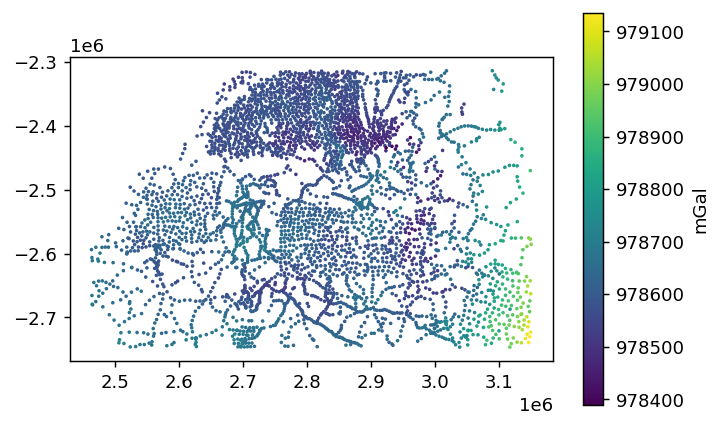

In [11]:
tmp = plt.scatter(data.easting, data.northing, c=data.gravity, s=1)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.show()

## Compute Bouguer gravity disturbance

The _Bouguer gravity disturbance_ is defined as:

$$ \delta bg(P) = \delta g(P) - g_{topo}(P) $$

The gravitational effect of the topography ($g_{topo}(P)$) is calculated in a plane Earth approximation by forward modelling using prisms. 

**Steps:**
* Load a digital elevation model (DEM) of the survey area.
* Project the DEM to plain coordinates.
* Compute Bouguer gravity disturbance by forward modelling the topography with prisms.

To do this, we will use **[Harmonica]( www.fatiando.org/harmonica )**.


### Load a DEM of South Africa (ETOPO1)

In [12]:
url = "https://github.com/fatiando/transform21/raw/main/data/bushveld_topography.nc"
fname = pooch.retrieve(url, known_hash=None, fname="bushveld_topography.nc")

topography = xr.load_dataset(fname)
topography

<xarray.Dataset>
Dimensions:    (latitude: 240, longitude: 419)
Coordinates:
  * longitude  (longitude) float64 25.02 25.03 25.05 25.07 ... 31.95 31.97 31.98
  * latitude   (latitude) float64 -27.0 -26.98 -26.97 ... -23.05 -23.03 -23.02
Data variables:
    bedrock    (latitude, longitude) float64 1.257e+03 1.26e+03 ... 241.0 238.0
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        ETOPO1 Bedrock Relief
    GMT_version:  4.4.0
    node_offset:  0
    doi:          10.7289/V5C8276M

In [13]:
# Extract the topography as a xarray.DataArray:
topography = topography.bedrock
topography

<xarray.DataArray 'bedrock' (latitude: 240, longitude: 419)>
array([[1257., 1260., 1266., ...,  195.,  201.,  425.],
       [1245., 1254., 1261., ...,  206.,  215.,  375.],
       [1256., 1258., 1268., ...,  200.,  232.,  300.],
       ...,
       [1029., 1031., 1033., ...,  248.,  242.,  238.],
       [1029., 1031., 1033., ...,  247.,  242.,  237.],
       [1028., 1030., 1032., ...,  247.,  241.,  238.]])
Coordinates:
  * longitude  (longitude) float64 25.02 25.03 25.05 25.07 ... 31.95 31.97 31.98
  * latitude   (latitude) float64 -27.0 -26.98 -26.97 ... -23.05 -23.03 -23.02
Attributes:
    long_name:       Bedrock relief
    actual_range:    [-10898.   8271.]
    units:           meters
    vertical_datum:  sea level
    datum:           WGS84

### Project the topography to plain coordinates

In [14]:
# Project the topography coordinates as a new DataArray
topo_plain = vd.project_grid(topography, projection=projection)
topo_plain

<xarray.DataArray 'bedrock' (northing: 240, easting: 419)>
array([[1257.        , 1260.        , 1266.        , ...,  195.        ,
         201.        ,  425.        ],
       [1245.19963571, 1254.09981785, 1261.08318154, ...,  205.8170006 ,
         214.76709167,  375.83181545],
       [1255.63559308, 1257.86748839, 1267.76810468, ...,  200.19876741,
         243.03929084,  320.85111308],
       ...,
       [1029.03190101, 1031.        , 1033.03190101, ...,  248.06380202,
         242.67730034,  238.41908245],
       [1028.67199134, 1030.67199134, 1032.67199134, ...,  247.34398268,
         241.90131312,  237.80956374],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])
Coordinates:
  * easting   (easting) float64 2.464e+06 2.466e+06 ... 3.148e+06 3.15e+06
  * northing  (northing) float64 -2.746e+06 -2.745e+06 ... -2.318e+06 -2.316e+06
Attributes:
    metadata:  Generated by Chain(steps=[('mean',\n              BlockReduce(...

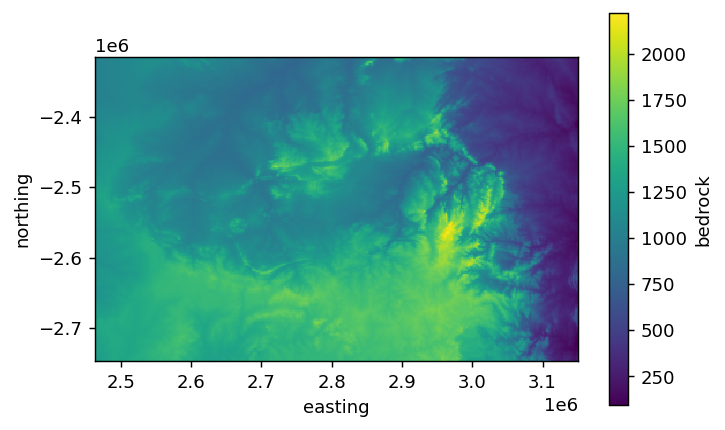

In [15]:
topo_plain.plot()
plt.gca().set_aspect("equal")
plt.show()

### Model topography with prisms

In [16]:
# Create the prisms xarray.Dataset from the topography:
prisms_centers = (topo_plain.easting.values, topo_plain.northing.values)
surface = topo_plain.values
density = 2670 * np.ones_like(surface) # assign density values to the prisms 

topo_prisms = hm.prism_layer(
    prisms_centers,
    surface=surface,
    reference=0,
    properties={"density": density}
)
topo_prisms

<xarray.Dataset>
Dimensions:   (easting: 419, northing: 240)
Coordinates:
  * easting   (easting) float64 2.464e+06 2.466e+06 ... 3.148e+06 3.15e+06
  * northing  (northing) float64 -2.746e+06 -2.745e+06 ... -2.318e+06 -2.316e+06
    top       (northing, easting) float64 1.257e+03 1.26e+03 ... nan nan
    bottom    (northing, easting) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Data variables:
    density   (northing, easting) float64 2.67e+03 2.67e+03 ... 2.67e+03
Attributes:
    coords_units:      meters
    properties_units:  SI

### Compute the gravitational effect of the layer of prisms

In [17]:
# Define the coordinates where we are going to calculate the gravity effect of the prisms
coordinates = (data.easting.values, data.northing.values, data.elevation.values)

# Use the "prism_layer" accessor to compute gravity field of the layer
result = topo_prisms.prism_layer.gravity(coordinates, field="g_z")

### Compute the Bouguer gravity disturbance

In [18]:
bouguer_disturbance = data.gravity_disturbance - result
# Add the bouguer_disturbance to the dataset as a column 
data = data.assign(bouguer_disturbance=bouguer_disturbance)

data

,latitude,longitude,elevation,gravity,easting,northing,gravity_disturbance,bouguer_disturbance
8848,-26.26334,25.01500,1230.16,978681.38,2.463751e+06,-2.665630e+06,16.654699,-89.092235
8849,-26.38713,25.01932,1297.00,978669.02,2.464176e+06,-2.679160e+06,16.031458,-104.233571
8850,-26.39667,25.02499,1304.84,978669.28,2.464735e+06,-2.680203e+06,18.024250,-110.448080
8851,-26.07668,25.04500,1165.24,978681.08,2.466705e+06,-2.645257e+06,9.665660,-112.583027
8852,-26.35001,25.07668,1262.47,978665.19,2.469826e+06,-2.675101e+06,4.215785,-132.141105
...,...,...,...,...,...,...,...,...
13174,-23.86333,31.51500,300.53,978776.85,3.103942e+06,-2.406088e+06,-8.543559,-41.410098
13175,-23.30000,31.52499,280.72,978798.55,3.104926e+06,-2.345890e+06,44.319034,14.557397
13176,-23.19333,31.54832,245.67,978803.55,3.107224e+06,-2.334520e+06,45.481540,21.350440
13177,-23.84833,31.57333,226.77,978808.44,3.109687e+06,-2.404481e+06,1.280373,-22.300864


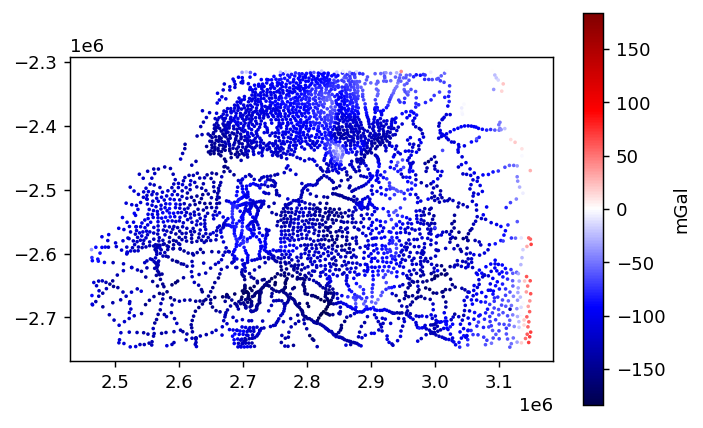

In [19]:
maxabs = vd.maxabs(data.bouguer_disturbance)
tmp = plt.scatter(
    data.easting, data.northing, c=data.bouguer_disturbance, s=1, vmin=-maxabs, vmax=maxabs, cmap="seismic"
)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.show()

## Compute residuals: remove regional trend

A common processing step is the removal of 2D polyomial trends from the data. 
This often helps interpolation methods which can struggle to recover the long wavelengths of data.

To compute the residual, we will use [Verde](https://www.fatiando.org/verde).

In [20]:
# Compute the trend from the Bouguer disturbance using a second-order polynomial:
trend = vd.Trend(degree=2)
trend.fit(coordinates, data.bouguer_disturbance)

# Remove the trend from the Bouguer disturbance:
residuals = data.bouguer_disturbance - trend.predict(coordinates)

In [21]:
# Add the residual to the dataset as a column: 
data = data.assign(bouguer_residuals=residuals)
data

,latitude,longitude,elevation,gravity,easting,northing,gravity_disturbance,bouguer_disturbance,bouguer_residuals
8848,-26.26334,25.01500,1230.16,978681.38,2.463751e+06,-2.665630e+06,16.654699,-89.092235,20.993574
8849,-26.38713,25.01932,1297.00,978669.02,2.464176e+06,-2.679160e+06,16.031458,-104.233571,5.680683
8850,-26.39667,25.02499,1304.84,978669.28,2.464735e+06,-2.680203e+06,18.024250,-110.448080,-0.449056
8851,-26.07668,25.04500,1165.24,978681.08,2.466705e+06,-2.645257e+06,9.665660,-112.583027,-1.874502
8852,-26.35001,25.07668,1262.47,978665.19,2.469826e+06,-2.675101e+06,4.215785,-132.141105,-20.996706
...,...,...,...,...,...,...,...,...,...
13174,-23.86333,31.51500,300.53,978776.85,3.103942e+06,-2.406088e+06,-8.543559,-41.410098,15.873228
13175,-23.30000,31.52499,280.72,978798.55,3.104926e+06,-2.345890e+06,44.319034,14.557397,56.942054
13176,-23.19333,31.54832,245.67,978803.55,3.107224e+06,-2.334520e+06,45.481540,21.350440,59.887857
13177,-23.84833,31.57333,226.77,978808.44,3.109687e+06,-2.404481e+06,1.280373,-22.300864,32.974734


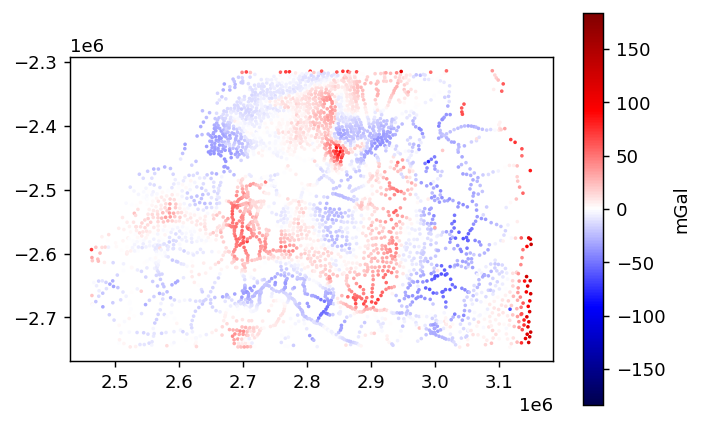

In [22]:
maxabs = vd.maxabs(data.bouguer_disturbance)
tmp = plt.scatter(
    data.easting, data.northing, c=data.bouguer_residuals, s=1, vmin=-maxabs, vmax=maxabs, cmap="seismic"
)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.show()

## Grid the residuals

To grid the residuals disturbance, we will use the _equivalent layer method_. 
The advantage of using this method is that it takes into account the 3D nature of the observations, not just their horizontal positions. 
It also allows data uncertainty to be taken into account and noise to be suppressed though the least-squares fitting process. 

For this processing we are going to use the [Harmonica](https://www.fatiando.org/harmonica).

In [23]:
# Create the equivalent layer:
eql = hm.EQLHarmonic(damping=1e2, relative_depth=5e3)  # The damping parameter helps smooth the predicted data and ensure stability.

# Fit the layer coefficients to the observed residual disturbance:
eql.fit(coordinates, data.bouguer_residuals.values)

EQLHarmonic(damping=100.0, relative_depth=5000.0)

In [24]:
data.elevation.max()

2144.0

In [25]:
# Interpolate data onto a regular grid:
grid = eql.grid(
    upward=2200, #we are setting the layer a little over the max elevation
    region=region_deg,
    spacing=0.01,
    data_names=["bouguer_residuals"],
    dims=("latitude", "longitude"),
    projection=projection,
)
grid

<xarray.Dataset>
Dimensions:            (latitude: 401, longitude: 701)
Coordinates:
  * longitude          (longitude) float64 25.0 25.01 25.02 ... 31.98 31.99 32.0
  * latitude           (latitude) float64 -27.0 -26.99 -26.98 ... -23.01 -23.0
    upward             (latitude, longitude) float64 2.2e+03 2.2e+03 ... 2.2e+03
Data variables:
    bouguer_residuals  (latitude, longitude) float64 -1.207 -1.219 ... 11.62
Attributes:
    metadata:  Generated by EQLHarmonic(damping=100.0, relative_depth=5000.0)

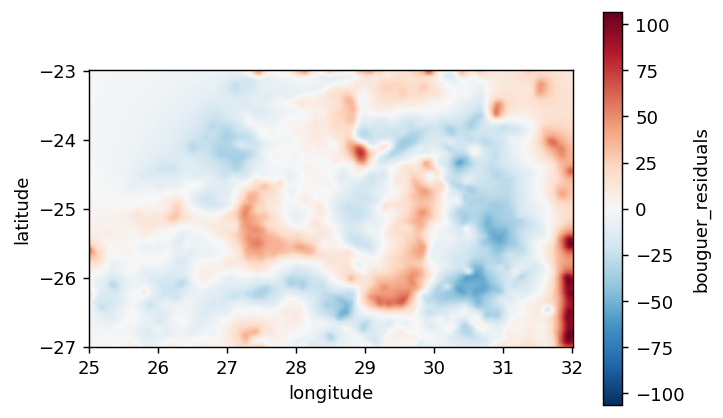

In [26]:
grid.bouguer_residuals.plot()
plt.gca().set_aspect("equal")
plt.show()

In [27]:
# Mask grid points that are outside the convex hull of the given data points:
grid = vd.convexhull_mask(data_coordinates=(data.longitude.values, data.latitude.values), grid=grid)
grid

<xarray.Dataset>
Dimensions:            (latitude: 401, longitude: 701)
Coordinates:
  * longitude          (longitude) float64 25.0 25.01 25.02 ... 31.98 31.99 32.0
  * latitude           (latitude) float64 -27.0 -26.99 -26.98 ... -23.01 -23.0
    upward             (latitude, longitude) float64 2.2e+03 2.2e+03 ... 2.2e+03
Data variables:
    bouguer_residuals  (latitude, longitude) float64 nan nan nan ... nan nan nan
Attributes:
    metadata:  Generated by EQLHarmonic(damping=100.0, relative_depth=5000.0)

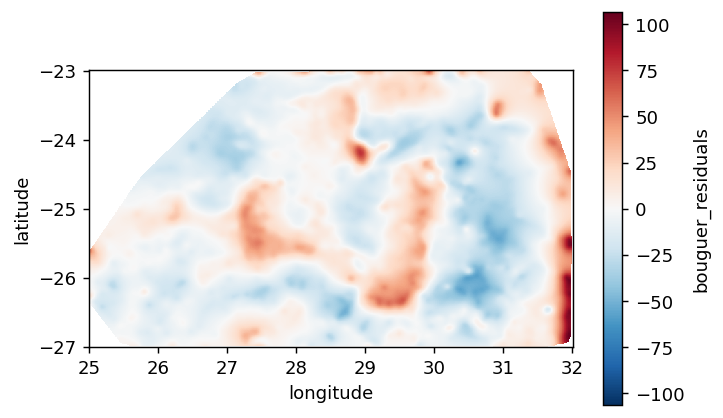

In [28]:
grid.bouguer_residuals.plot()
plt.gca().set_aspect("equal")
plt.show()

## Extract a profile

We will interpolate the residual disturbance along a profile between two points using equivalent layer.

In [29]:
point1 = (26, -25) # easting, northing 
point2 = (31, -25) 

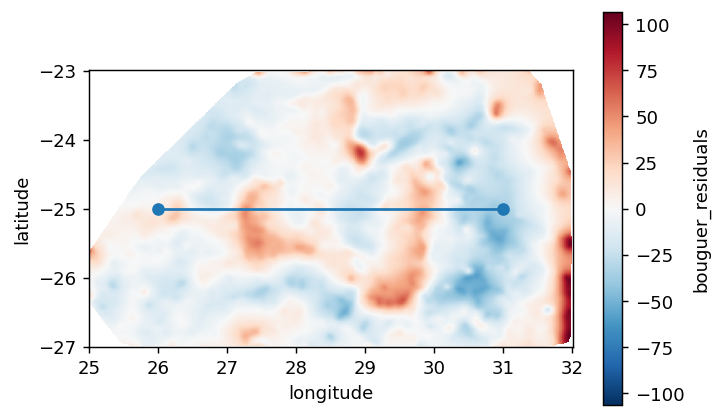

In [30]:
grid.bouguer_residuals.plot()
plt.plot([point1[0], point2[0]], [point1[1], point2[1]], "o-")
plt.gca().set_aspect("equal")
plt.show()

In [31]:
# Interpolate the data from the equivalent layer generated in section 1.7:
profile = eql.profile(
    point1=point1,
    point2=point2,
    upward=data.elevation.max(),
    size=200,
    data_names=["bouguer_residuals"],
    projection=projection,
)
profile

,northing,easting,distance,upward,bouguer_residuals
0,-25.0,26.000000,0.000000,2144.0,5.619023
1,-25.0,26.025126,2474.646633,2144.0,6.117148
2,-25.0,26.050251,4949.293266,2144.0,6.673721
3,-25.0,26.075377,7423.939898,2144.0,7.326558
4,-25.0,26.100503,9898.586531,2144.0,8.209198
...,...,...,...,...,...
195,-25.0,30.899497,482556.093397,2144.0,-37.632524
196,-25.0,30.924623,485030.740030,2144.0,-37.443253
197,-25.0,30.949749,487505.386663,2144.0,-37.047922
198,-25.0,30.974874,489980.033295,2144.0,-36.411274


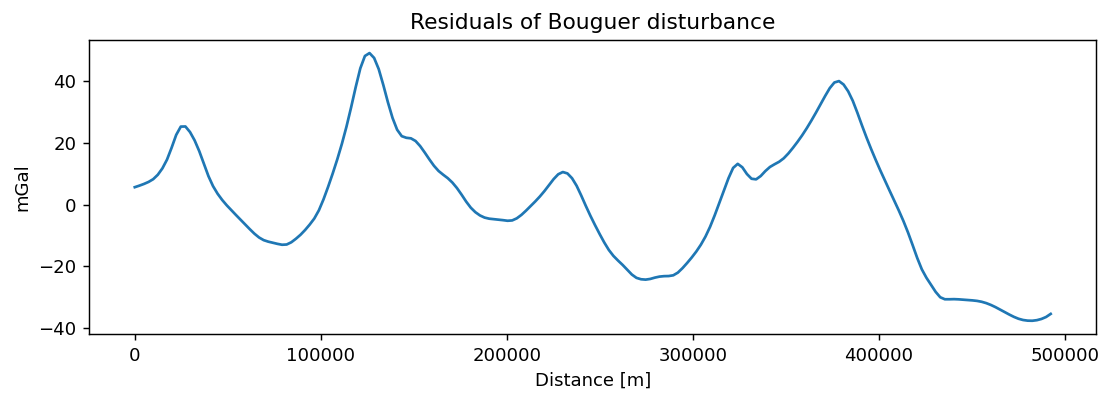

In [32]:
# Plot the profile using mathplotlib:
plt.plot(profile.distance, profile.bouguer_residuals)
plt.ylabel("mGal")
plt.xlabel("Distance [m]")
plt.title("Residuals of Bouguer disturbance")
plt.gcf().set_size_inches(10, 3)
plt.show()

## Save results

In [33]:
data.to_csv("south-africa-gravity-disturbance.csv")

In [34]:
grid.to_netcdf("south-africa-residuals.nc")